In [234]:
import pandas as pd
import numpy as np

from shutil import copy
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from actsnclass.metrics import get_snpcc_metric
from actsnfink import *
import matplotlib.pylab as plt
import pickle
from actsnclass.metrics import get_snpcc_metric


import requests
import io

In [41]:
# read data

date_before = '20230921'

train = pd.read_csv('/media/emille/git/Fink/supernova_al/repository/al_real_time/data/' + \
                    date_before + '/UncSampling/training_samples/initialtrain_v0.csv')
print('Initial training: ', train.shape[0])

test = pd.read_csv('/media/emille/git/Fink/supernova_al/repository/al_real_time/data/' + \
                   date_before + '/UncSampling/test_samples/initial_test_v0.csv')
print('Initial test: ', test.shape[0])

query = pd.read_csv('/media/emille/git/Fink/supernova_al/repository/al_real_time/data/' + \
                    date_before + '/UncSampling/queries/queried_UncSampling_v0.dat', skiprows=1,
                   names=['day', 'objectId', 'type'] + list(train.keys())[:-2], index_col=False)
print('Query: ', query.shape[0])

Initial training:  10
Initial test:  23765
Query:  30


In [21]:
# make sure there is no test/train overlap
flag_overlap = np.isin(test['objectId'].values, train['objectId'].values)

if sum(flag_overlap) > 0:
    raise ValueError('There are repeated objects in training and test.')

In [42]:
# remove queried objects from test
flag_query = np.isin(test['objectId'].values, query['objectId'].values)
if sum(flag_query) != query.shape[0]:
    raise ValueError('Not all objects in query were found. Missing: ', query.shape[0] - sum(flag_query))
    
test_updated = deepcopy(test[~flag_query]).reset_index()
print('Updated test: ', test_updated.shape[0])
    
# add them to train
train_updated = pd.concat([train, test[flag_query]], ignore_index=True)
print('Updated train: ', train_updated.shape[0])

Updated test:  23735
Updated train:  40


In [245]:
header = list(train_updated.keys())[:-3]

clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(train_updated[header], train_updated['type'].values == 'Ia')

pred = clf.predict(test_updated[header])
get_snpcc_metric(pred, test_updated['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [0.952728038761323,
  0.48358585858585856,
  0.7158878504672898,
  0.22075492710176856])

In [162]:
# new labels from 2.3m

new_labels = pd.DataFrame


new_data = np.array([['ZTF23abceaws', 'other', 2460215.5000000],
            ['ZTF23abdhvou', 'SN Ia', 2460212.5000000],
            ['ZTF23abecphw', 'other', 2460208.5000000],
            ['ZTF23abeqble', 'other', 2460214.5000000],
            ['ZTF23abhtkba', 'other', 2460222.5000000],
            ['ZTF23abeudve', 'SN Ia', 2460222.5000000],
            ['ZTF23abhafym', 'SN Ia', 2460226.5000000]])
    
new_data_pd = pd.DataFrame(new_data, columns=['objectId', 'TNS', 'jd_query'])

In [156]:
# get data for ZTF19acnjwgm
alerts_list = []

for i in range(new_data_pd.shape[0]):
    
    name = new_data_pd.iloc[i]['objectId']
    r = requests.post(
        'https://fink-portal.org/api/v1/objects',
        json={
            'objectId':name,
            'output-format': 'json'
        }
    )

    # Format output in a DataFrame
    pdf = pd.read_json(io.BytesIO(r.content))
    if pdf.shape[0] == 0:
        raise ValueError('No alerts found for object: ', name)
        
    # add label
    pdf['TNS'] = new_data_pd.iloc[i]['type'] 

    alerts_list.append(pdf)
    
alerts_pd = pd.concat(alerts_list, ignore_index=True)


In [165]:
# feature extract new data

alerts_format_list = []

for indx_obj in range(new_data_pd.shape[0]):
    # isolate one object
    flag_obj = alerts_pd['i:objectId'].values == new_data_pd['objectId'].values[indx_obj]

    # separate only dates until the alert was sent to follow-up
    cjd = alerts_pd[flag_obj]['i:jd'].values
    flag_jd = cjd < float(new_data_pd.iloc[indx_obj]['jd_query'])
    
    lc = pd.DataFrame([[new_data_pd.iloc[indx_obj]['objectId'], 
                        alerts_pd[flag_obj]['i:candid'].values[flag_jd][np.argsort(alerts_pd[flag_obj]['i:jd'].values[flag_jd])[-1]],
                        alerts_pd[flag_obj]['i:jd'].values[flag_jd],         
                        alerts_pd[flag_obj]['i:fid'].values[flag_jd], 
                        alerts_pd[flag_obj]['i:magpsf'].values[flag_jd],
                        alerts_pd[flag_obj]['i:sigmapsf'].values[flag_jd],
                        new_data_pd.iloc[indx_obj]['TNS']]], 
                        columns=['objectId', 'candid', 'cjd', 'cfid', 'cmagpsf', 'csigmapsf', 'TNS'], index=[0], dtype=object)
    
    alerts_format_list.append(lc)
    
alerts_format_pd = pd.concat(alerts_format_list, ignore_index=True)

In [171]:
# convert from mag to FLUXCAL
alerts_flux = convert_full_dataset(alerts_format_pd, obj_id_header='objectId')

In [172]:
alerts_features = featurize_full_dataset(alerts_flux, screen=False)

In [209]:
# filter alerts with zero in all filters
flag_zero = np.logical_or(alerts_features['a_g'].values == 0.0,
                           alerts_features['a_r'].values == 0.0)

alerts_use = deepcopy(alerts_features[~flag_zero])

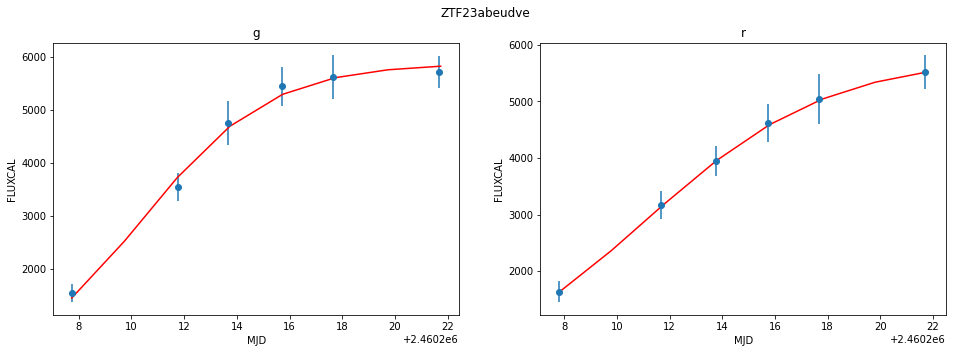

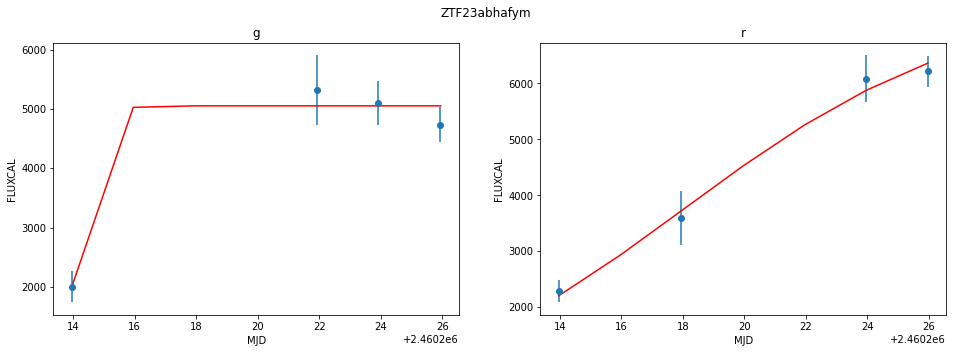

In [211]:
f = ['g', 'r']

for indx in range(alerts_use.shape[0]):

    obj_id = alerts_use.iloc[indx]['id']
    obj_flag = alerts_flux['id'].values == obj_id

    plt.figure(figsize=(16,5))
    plt.suptitle(obj_id)

    for i in range(2):
        flag_filter = np.logical_and(obj_flag, alerts_flux['FLT'].values == f[i])
    
        flag_comb = np.logical_and(flag_filter, obj_flag)
        lc = alerts_flux[flag_comb]
    
        x = np.arange(0, max(lc['MJD'].values) - min(lc['MJD'].values) +1, 2)
        flag_obj2 = alerts_features['id'].values == obj_id
        y = fsigmoid(x, alerts_features[flag_obj2]['a_' + f[i]].values[0], 
                    alerts_features[flag_obj2]['b_' + f[i]].values[0],
                    alerts_features[flag_obj2]['c_' + f[i]].values[0]) 
    
        plt.subplot(1,2,i+1)
        plt.title(f[i])
        plt.errorbar(lc['MJD'], lc['FLUXCAL'], yerr=lc['FLUXCALERR'], fmt='o', label='obs')
        plt.plot(min(lc['MJD'].values) + x,y, color='red', label='reconstruction')
        plt.xlabel('MJD')
        plt.ylabel('FLUXCAL')
    
    plt.show()

In [213]:
train_updated_again = pd.concat([train_updated, alerts_use], ignore_index=True)

In [215]:
train_updated_again.keys()

Index(['a_g', 'b_g', 'c_g', 'snratio_g', 'mse_g', 'nrise_g', 'a_r', 'b_r',
       'c_r', 'snratio_r', 'mse_r', 'nrise_r', 'objectId', 'type', 'id'],
      dtype='object')

In [246]:
header = list(train_updated_again.keys())[:-3]

clf = RandomForestClassifier(random_state=42, n_estimators=1000)
clf.fit(train_updated_again[header], train_updated_again['type'].values == 'Ia')

RandomForestClassifier(n_estimators=1000, random_state=42)

In [247]:
clf.score(train_updated_again[header], train_updated_again['type'].values == 'Ia')

1.0

In [248]:
clf.score(test_updated[header], test_updated['type'].values == 'Ia')

0.948093532757531

In [249]:
pred = clf.predict(test_updated[header])
pred_prob = clf.predict_proba(test_updated[header])

In [250]:
get_snpcc_metric(pred, test_updated['type'].values == 'Ia')

(['accuracy', 'efficiency', 'purity', 'fom'],
 [0.948093532757531,
  0.4823232323232323,
  0.6496598639455783,
  0.18424747474747474])

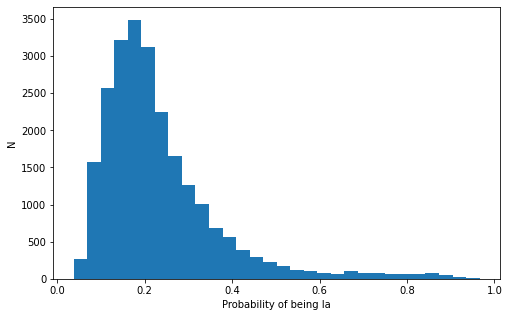

In [224]:
plt.figure(figsize=(8,5))
plt.hist(pred_prob[:,1], bins=30)
plt.ylabel('N')
plt.xlabel('Probability of being Ia')
plt.show()

In [229]:
date_now = '20231009'

dirname = '/media/emille/git/Fink/supernova_al/repository/al_real_time/data/' + date_now + '/' 
pickle.dump(clf, open(dirname + 'UncSampling/models/model_' + date_now + '.pkl', 
                      'wb'))

In [239]:
# copy model to fink-science
copy(dirname + '/UncSampling/models/model_' + date_now + '.pkl', 
     '/media/emille/git/Fink/fink-science/fink_science/data/models/for_al_loop/model_' + date_now + '.pkl')

'/media/emille/git/Fink/fink-science/fink_science/data/models/for_al_loop/model_20231009.pkl'

In [240]:
import sklearn

In [241]:
sklearn.__version__

'1.0.2'

In [252]:
train_updated_again.to_csv('/media/emille/git/Fink/supernova_al/repository/al_real_time/' + \
                           'data/' + date_now +'/UncSampling/training_samples/train_updated_again.csv', index=False)

In [253]:
test_updated.to_csv('/media/emille/git/Fink/supernova_al/repository/al_real_time/' + \
                           'data/' + date_now + '/UncSampling/test_samples/test_updated.csv', index=False)

In [254]:
alerts_use.to_csv('/media/emille/git/Fink/supernova_al/repository/al_real_time/' + \
                           'data/' + date_now + '/UncSampling/queries/queries_real_data.csv', index=False)